In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***CrewIA with 3 agents***

In [ ]:
%%capture
!pip install crewai

In [ ]:
from crewai import Agent, Task, Crew, Process, LLM
#from crewai_tools import SerperDevTool , FileReadTool
from google.colab import userdata
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier


In [ ]:
os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["OPENIA_API_KEY"] = userdata.get("OPENIA_API_KEY")
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

In [ ]:
gemini = LLM(
    #model='gemini/gemini-1.5-flash',
    model = 'gemini/gemini-2.0-flash',
    temperature=0.7
)
groq_llama_3 = LLM(
    #model='groq/llama3-70b-8192',
    model = 'groq/llama-3.1-8b-instant',
    temperature=0.7
)
groq_llama = LLM(
    model = "groq/llama-3.3-70b-versatile",
    #model = "groq/lama3-8b-8192",
    temperature=0.9
)

grog_mixtral = LLM(
    model = "groq/mixtral-8x7b-32768",
    temperature=0.9
)

In [ ]:
transaction_generator_agent = Agent(
    role="Generate Bank Transactions ",
    goal = "Générer des observations de transactions bancaires synthétiques réalistes effectuées avec des cartes " ,
    backstory = "Vous avez plusieurs années d'expériences sur la génération de données synthétiques bancaires du Sénégal effectuées avec les cartes" ,
    max_rpm=3,
    verbose=True,
    llm=groq_llama_3
    #llm=gemini
)

In [ ]:
rules_agent = Agent(
    role = "implement detection rules on banking observations" ,
    goal = "Analyse le comportement de chaque client générées par l'agent {transaction_generator_agent}  puis Met en place des règles ou stratégies \
    concernant chaque client pour identifier ou  détecter leurs futurs transactions pour des cas normal,suspects et de fraudes" ,
    backstory = "Expert dans le suivi du comportement des clients pour l'identification de leurs futurs transactions Normales, Suspectes et Frauduleuses " ,
    max_rpm = 3,
    max_iter = 10 ,
    cache=True ,
    verbose = True,
    allow_delegation = False,
    #llm=grog_mixtral
    llm = groq_llama_3
)


In [ ]:
generator_agent = Agent(
    role = "Generate card transactions using agent {transaction_generator_agent} information" ,
    goal = "Générer de nouvelles transactions bancaires (avec cartes) synthétiques réalistes avec les  memes clients que l'agent {transaction_generator_agent} \
    a généré et aussi avec les memes colonnes.",
    backstory = "Spécialisé dans la génération de données réalistes pour les transactions bancaires effectuées avec  des cartes afin de les utiliser pour \
    tester des modèles de détection de fraudes ou d'autres systèmes  bancaires" ,
    max_rpm = 3,
    max_iter = 10 ,
    cache=True ,
    verbose = True,
    allow_delegation = False,
    #llm=grog_mixtral
    llm = groq_llama
    #llm=gemini
)


In [ ]:
transaction_classifier_agent = Agent(
    role = "Classification of banking transaction",
    goal = "Classification des nouvelles transactions générées par l'agent {generator_agent} par biais des règles que l'agent {rules_agent} a"
            "mis en place pour le suivi du comportement de chaque client généré par l'agent {transaction_generator_agent}." ,
    backstory = "Spécialiste de la classification automatique des transactions bancaires en 3 catégories : Fraude, Suspect et Normal."
                "Vous vous basez sur les règles mis en place par l'agent {rules_agent} pour la classification de chaque client. " ,
    max_rpm = 3 ,
    max_iter = 10 ,
    cache=True ,
    verbose=True,
    allow_delegation = False,
    llm=gemini
    #llm = groq_llama,
    #llm = groq_llama_3
)

In [ ]:
generator_task = Task(
      name="Generate bank Transactions",
      agent=transaction_generator_agent,
      description= "Utilise les types de transactions suivants ATM, Paiement en ligne et Paiement électronique aléatoirement pour \
      générer {n_obs_ref} transactions ou observations bancaires synthéthiques  réalistes (en utilisant les cartes) de {n_client} clients d'une banque sénégalaise nommé 'SenBank' pour une \
      période de  {nb_month} mois avec les colonnes suivantes : ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant. Les transactions \
      peuvent  s'effectuer dans tout les régions du Sénégal et sont soit 'Validé' ou 'En attente' ou 'Echoué'. Les observations simulées doivent etre comme \
      les observations réelles qui peuvent tromper la  vigilance des personnes sur la véracité des données. Le client doit avoir plusieurs (plus de 5) zones de localisaton où il \
      a l'habitude de faire ses opérations de transaction. Générez des codes clients aléatoires compris entre 50000 et 80000 et des numéro de comptes commençant par 85 (exemple : 850578, 85458321).\
      Le code client est associé à un seul numéro compte et réprésente l'identifiant du client. Un numéro de compte doit avoir 6 à 12 chiffres (entre 850000 et 859999999999). L'identifiant de \
      l'opération doit commencer par 'TR' et peut contenir des lettres et chiffres (par exemple TR0AHB8L) avec 8 caractères. Pour chaque colonne citée ci-dessus, simulez des données avec les types les plus appropriées. Chaque \
      client doit avoir au moins {nb_month} transactions dans le résultat final, c'est à dire que chaque client aura au moins une transaction par mois. Ses transactions simulées doivent commencer à partir \
      du 1ère mois 2023 au {nb_month}ième mois 2023. Faites de telles sortes que, les transactions simulées soient sur {nb_month} mois. Générez des données avec des montants faible, moyen et élevé mais qui \
      sont réalistes avec le type de transaction effectuée (ATM, Paiement en ligne,  Paiement électronique). Par rapport aux montants des transactions, simulez des observations avec  des montants allant de \
      '1 000 FCFA' à plus de '10 000 000' et des dates de format 'jour/mois/année Heure:minute' (exemple : 25/04/2024 22:00), mettez les transactions simulées en ordres en allant du plus \
      récents au plus anciens. Sur le contenu de la colonne montant, mettez la valeur uniquement sans l'expression FCFA. Respectez le format de dates qui est donné. Les données simulées \
      doivent refléter la réalité de la société sénégalaise." ,

      expected_output = "Une historiques de {n_obs_ref} observations de transactions bancaires (avec carte) synthétiques d'une banque  sénégalaise pour une durée de \
      {nb_month} mois qui sera enrégistrer dans un fichier 'Transaction.csv' en utilisant ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,\
      Localisation;Date,Montant comme entetes et ';' comme  délimiter et qui sera accessible par les autres agents et utilisateurs. Les entetes doivent etre au premier ligne du fichier.\
      Le  fichier doit contenir que les observations uniquement pas de caractère (``` ou ```text ou ```csv) ou chaine caractère   au dessus et en dessous et le contenu de la sortie sera\
      en français. Ce n'est pas la peine d'ajouter  des commentaires au dessus de la sortie du fichier de meme qu'à la fin.",
      output_file = "Transaction.csv" ,
      max_rpm = 3,
        )

In [ ]:
ruler_task = Task(
      name="Fraud and suspicious detection",
      agent=rules_agent,
      description= "Analyse le comportement de chaque client généré par l'agent {transaction_generator_agent} par  exemple son nombre de transaction par mois ou par semaine,\
      les zones qu'il a l'habitube de faire  ses transactions (exemple : une transaction dans une région ou un pays inhabituel peut être  suspecte), les fréquences de localisation \
      (exemple : une carte utilisée à Dakar à 14h et à Kédougou  à 14h05 peut etre suspecte), son montant moyen, l'intervalle de ses montants de transaction, ses  types de \
      transactions habituelles, ses horaires habituels (intervalle d'heure par exemple 9H-20H),  le statut de ses opérations (exemple : Plusieurs transactions échouées avant une\
      transaction réussie  peut signaler des tentatives suspectes)... puis utilise le résultat de l'analyse de chaque client  pour mettre en place un ensemble de règles pour chaque\
      client afin d'identifier leurs futurs  transactions suspectes, frauduleus et normales. Notez bien qu'une transaction suspecte et  frauduleuse sont différents. La \
      variable 'Code clients' répresente l'identifiant des clients. Donc  prenez cela en compte pour les règles qui seront mis en place pour les clients.Sachez que la  sortie des règles\
      sont au nombre de 3 : normal, suspecte et fraude. Donnez les règles sous forme de texte mais pas sous forme de code." ,

      expected_output= "Un ensemble de règles ou stratégies de tout les clients pour détecter les cas Normals, Suspects  et de Fraudes pour leurs futurs \
      transactions. Enrégistrer les règles mis en place sur tout les clients  sur un fichier 'Regles.txt'." ,

      output_file = "Regles.txt" ,
      context = [generator_task, ],
      max_rpm = 3,

        )

In [ ]:
new_generator_task = Task(
      name="Generate New Transactions",
      agent=generator_agent,
      description= "Recupère les codes clients et leurs numéros de compte associé qui ont été générées par l'agent {transaction_generator_agent} et utilise les types de transactions\
      suivants ATM, Paiement en ligne et Paiement  électronique aléatoirement pour générer {n} nouvelles transactions bancaires synthéthiques  réaliste avec les memes colonnes que les \
      premiers transactions simulées par l'agent  {transaction_generator_agent} (Code clients,Numero de compte, Identifiant operation,  type de transaction,status operation, localisation,\
      date, montant). Les observations doivent etre comme des observations réelles qui  peuvent tromper la vigilance des personnes sur la véracité des données. Les transactions ATM sont les\
      plus fait par les clients dans la réalité. L'identifiant de l'opération doit commencer par 'TR' et peut contenir des chiffres et des lettres. Regarder sur les transactions générées\
      par l'agent {transaction_generator_agent} le dernier mois qui a été généré et les transactions qui seront générées à nouveau pour cette tache seront sur les {nb_month} prochaines mois\
      de ce mois trouvé. Autrement dit, Ses transactions doivent commencer à partir du mois suivant du dernière mois des transaction de l'agent {transaction_generator_agent}. Par exemple, \
      si la dernière transaction simulée par l'agent {transaction_generator_agent} est en Avril, les transactions qui seront simulées doivent commencer à partir du mois de Mai. Chaque \
      client doit avoir au moins une transaction effectuée par mois et mettez les observations en ordre chronologiques du plus récents au plus anciens. Faites de telles sortes que, les données qui \
      seront simulées soient sur {nb_month} mois ou plus et ne simulez  jamais des observations ayant comme date le deuxième mois 2025. En effet, la limite des dates pour les observations\
      est le 31/01/2025. Les transactions doivent avoir des dates inférieur au 31 Janvier 2025. Les  données générées doivent etre au meme format que les transactions de l'agent \
      {transaction_generator_agent} (meme colonnes et meme types de  données, meme code client et numéro de compte, etc.). En résumé votre tache est pratiquement le meme  que la tache\
      éxecutée par l'agent {transaction_generator_agent} pour la génération de données  bancaires synthétiques avec carte. Prenez tout le temps nécessaire pour générer le nombre exact de\
      transactions demandées ({n}) ni moins, ni plus, ne fait aucune point de suspension pour masquer ou omettre certains observations. Faite de tels sorte que si on applique les règles\
      de détection qui ont été défini par l'agent {rules_agent} sur les données qui seront générées qu'on aura au moins 95% de transactions normales" ,

      expected_output= "Un nouveau historique de {n} observations de transactions bancaires synthétiques sénégalaise   effectuée avec une carte avec les memes clients que l'agent\
      {transaction_generator_agent} avait  généré et avec les memes colonnes qui seront l'entete et qui sera enrégistrer dans un fichier  'New_Transaction.csv' en utilisant ';' comme  \
      délimiter et qui sera accessible par les autres  agents et utilisateurs. Le contenu de la sortie sera en français. Le fichier doit contenir que les  observations de transactions \
      uniquement pas de caractère ou chaine caractère au dessus et en dessous. Ce n'est pas la peine d'ajouter des commentaires au dessus de la sortie finale de meme qu'en dessous." ,

      context = [generator_task , ] ,
      max_rpm = 3,
        )

In [ ]:
classify_task = Task(
      name="Classify new Transactions",
      agent=transaction_classifier_agent,
      description= "Recupère tout les règles de l'agent {rules_agent} et les {n} observations de transactions générées  par l'agent {generator_agent}. Puis classe les observations des \
      clients en 3 catégories : Normal,  Suspect et Fraude en utilisant ses règles. Pour chaque client, utilise ses propres règles qui ont  été défini pour classer ses transactions. Ajoute\
      une colonne 'Target' pour le résultat de la  classification des observations. Le nouveau dataset doit garder le meme format que les données avant  classification." ,

      expected_output = "L'historique des {n} nouvelles observations de transactions générées par l'agent {generator_agent}  avec ses colonnes + la colonne 'Target' qui contient les \
      résultats de classification (Normal,  Suspect ou Fraude) des observations génénées. Le contenu de la sortie sera en français. L'historique  doit garder le format de données \
      initiale (avant classification). Celle-ci sera enrégistré sur un fichier 'Bank_transaction.csv' en utilisant ID Clients,Numero de compte,Identifiant operation,Type de  transaction,\
      Status operation,Localisation,Date,Montant,Target comme entetes et ';' comme délimiter et le ficier sera toujours accessible par les agents et utilisateurs. Les entetes seront au \
      premier ligne du fichier 'Bank_transaction.csv' ou de la sortie finale mais pas au deuxième ligne. Le sortie finale contiendra que les observations uniquement et ne doit pas avoir de\
      caractère  (par exemple ``` ou ```text ou ```csv) ou chaine caractère au dessus et en dessous du fichier. Ce n'est pas la peine d'ajouter des commentaires  au dessus de la sortie\
      finale de meme qu'en dessous (par exemple : ``` ou ```text ou ```csv)" ,

      output_file = "Bank_transaction.csv" ,
      max_rpm = 2,
      context = [ ruler_task, new_generator_task],
    )

In [ ]:
transaction_crew = Crew(
    agents = [
            transaction_generator_agent,
            rules_agent,
            generator_agent,
            transaction_classifier_agent
            ],

    tasks = [
             generator_task,
             ruler_task,
             new_generator_task,
             classify_task
             ],
    verbose = True
)

In [ ]:
inputs = {
    'n_client': 5 ,
    "n_obs_ref" : 30,
    "transaction_generator_agent" : " Generate Bank Transactions ",
    "rules_agent" : "implement detection rules on banking observations" ,
    "transaction_classifier_agent" : "Classification of banking transaction",
    "generator_agent" : "Generate card transactions using agent {transaction_generator_agent} information" ,
    "n" : 150 ,
    "nb_month" : 4 ,
    #'nb_month' : 3,
}

In [ ]:
transaction_crew.train(n_iterations=1, inputs = inputs, filename = 'train.txt')

╭─────────────────────────────────────────────── Training Started ────────────────────────────────────────────────╮
│                                                                                                                 │
│  📋 Crew Training Started                                                                                       │
│  Crew: crew                                                                                                     │
│  Time: 2025-05-09 14:30:09.541156                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: 330b390f-0d77-4f59-874f-2d97809c65a7                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
       Status: Executing Task...
    └── 🤖 Agent: Generate Bank Transactions 
            Status: In Progress

# Agent: Generate Bank Transactions 
## Task: Utilise les types de transactions suivants ATM, Paiement en ligne et Paiement électronique aléatoirement pour       générer 30 transactions ou observations bancaires synthéthiques  réalistes (en utilisant les cartes) de 5 clients d'une banque sénégalaise nommé 'SenBank' pour une       période de  4 mois avec les colonnes suivantes : ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant. Les transactions       peuvent  s'effectuer dans tout les régions du Sénégal et sont soit 'Validé' ou 'En attente' ou 'Echoué'. Les observations simulées doivent etre comme       les observations réelles qui peuvent tromper la  vigilance des personnes sur la véracité des données. Le client doit avoir plusieurs (plus de 5) zones de localisaton où il       a l'habitude de faire ses opérations de transaction. Générez des codes clients aléatoires compris entre 50000 et 80000 et des numéro de comptes comm

🤖 Agent: Generate Bank Transactions 
    Status: In Progress
└── 🧠 Thinking...

🤖 Agent: Generate Bank Transactions 
    Status: In Progress



# Agent: Generate Bank Transactions 
## Final Answer: 
Thought: Je suis prêt à générer les observations de transactions bancaires synthétiques réalistes pour la banque sénégalaise 'SenBank' conformément aux critères fournis. Je vais utiliser les langages Python et pandas pour simuler les données et les sauvegarder dans un fichier CSV nommé 'Transaction.csv'.


 ## Final Result: Thought: Je suis prêt à générer les observations de transactions bancaires synthétiques réalistes pour la banque sénégalaise 'SenBank' conformément aux critères fournis. Je vais utiliser les langages Python et pandas pour simuler les données et les sauvegarder dans un fichier CSV nommé 'Transaction.csv'.
 

=====
## TRAINING MODE: Provide feedback to improve the agent's performance.
This will be used to train better versions of the agent.
Please provide detailed feedback about the result quality and reasoning process.
=====

 
Processing your feedback...


# Agent: Generate Bank Transactions 
## Final Answer: 

🚀 Crew: crew
└── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
       Status: Executing Task...
    └── 🤖 Agent: Generate Bank Transactions 
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
       Assigned to: Generate Bank Transactions 
       Status: ✅ Completed
    └── 🤖 Agent: Generate Bank Transactions 
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: e5eae77f-78ee-4f14-8a96-6d56e8c08b13                                                                     │
│  Agent: Generate Bank Transactions                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
       Status: Executing Task...
    └── 🤖 Agent: implement detection rules on banking observations
            Status: In Progress

# Agent: implement detection rules on banking observations
## Task: Analyse le comportement de chaque client généré par l'agent  Generate Bank Transactions  par  exemple son nombre de transaction par mois ou par semaine,      les zones qu'il a l'habitube de faire  ses transactions (exemple : une transaction dans une région ou un pays inhabituel peut être  suspecte), les fréquences de localisation       (exemple : une carte utilisée à Dakar à 14h et à Kédougou  à 14h05 peut etre suspecte), son montant moyen, l'intervalle de ses montants de transaction, ses  types de       transactions habituelles, ses horaires habituels (intervalle d'heure par exemple 9H-20H),  le statut de ses opérations (exemple : Plusieurs transactions échouées avant une      transaction réussie  peut signaler des tentatives suspectes)... puis utilise le résultat de l'analyse de chaque client  pour mettre en place un ensemble de règles pour chaque      client afin d'identifier leurs futurs  transactions suspectes, fr

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
       Status: Executing Task...
    └── 🤖 Agent: implement detection rules on banking observations
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
       Assigned to: implement detection rules on banking observations
       Status: ✅ Completed
    └── 🤖 Agent: implement detection rules on banking observations
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 72c72fb5-1be0-4fa8-afce-95d147f14afc                                                                     │
│  Agent: implement detection rules on banking observations                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
       Status: Executing Task...
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: In Progress

# Agent: Generate card transactions using agent  Generate Bank Transactions  information
## Task: Recupère les codes clients et leurs numéros de compte associé qui ont été générées par l'agent  Generate Bank Transactions  et utilise les types de transactions      suivants ATM, Paiement en ligne et Paiement  électronique aléatoirement pour générer 150 nouvelles transactions bancaires synthéthiques  réaliste avec les memes colonnes que les       premiers transactions simulées par l'agent   Generate Bank Transactions  (Code clients,Numero de compte, Identifiant operation,  type de transaction,status operation, localisation,      date, montant). Les observations doivent etre comme des observations réelles qui  peuvent tromper la vigilance des personnes sur la véracité des données. Les transactions ATM sont les      plus fait par les clients dans la réalité. L'identifiant de l'opération doit commencer par 'TR' et peut contenir des chiffres et des lettres. Regarder sur les transactions génér

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
       Status: Executing Task...
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
       Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
       Status: ✅ Completed
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: ff62800c-515d-4e9f-a990-87fd994182fa                                                                     │
│  Agent: Generate card transactions using agent  Generate Bank Transactions  information                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: b22132c5-220d-4644-ae79-a60eb39a28bd
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: b22132c5-220d-4644-ae79-a60eb39a28bd
       Status: Executing Task...
    └── 🤖 Agent: Classification of banking transaction
            Status: In Progress

# Agent: Classification of banking transaction
## Task: Recupère tout les règles de l'agent implement detection rules on banking observations et les 150 observations de transactions générées  par l'agent Generate card transactions using agent {transaction_generator_agent} information. Puis classe les observations des       clients en 3 catégories : Normal,  Suspect et Fraude en utilisant ses règles. Pour chaque client, utilise ses propres règles qui ont  été défini pour classer ses transactions. Ajoute      une colonne 'Target' pour le résultat de la  classification des observations. Le nouveau dataset doit garder le meme format que les données avant  classification.


# Agent: Classification of banking transaction
## Final Answer: 
Okay, I understand the task. I need to classify banking transactions into three categories (Normal, Suspect, and Fraude) based on a set of rules. I have the transaction data and the rules defined by the agent. I will add a "Target" column to the data indica

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: b22132c5-220d-4644-ae79-a60eb39a28bd
       Status: Executing Task...
    └── 🤖 Agent: Classification of banking transaction
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: e5eae77f-78ee-4f14-8a96-6d56e8c08b13
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: 72c72fb5-1be0-4fa8-afce-95d147f14afc
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: ff62800c-515d-4e9f-a990-87fd994182fa
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: b22132c5-220d-4644-ae79-a60eb39a28bd
       Assigned to: Classification of banking transaction
       Status: ✅ Completed
    └── 🤖 Agent: Classification of banking transaction
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: b22132c5-220d-4644-ae79-a60eb39a28bd                                                                     │
│  Agent: Classification of banking transaction                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: 330b390f-0d77-4f59-874f-2d97809c65a7                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭────────────────────────────────────────────── Training Completed ───────────────────────────────────────────────╮
│                                                                                                                 │
│  ✅ Crew Training Completed                                                                                     │
│  Crew: crew                                                                                                     │
│  Time: 2025-05-09 14:56:39.533708                                                                               │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result = transaction_crew.kickoff(inputs = inputs)

╭──────────────────────────────────────────── Crew Execution Started ─────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Started                                                                                         │
│  Name: crew                                                                                                     │
│  ID: c7b61312-3af3-4207-bd90-0367331f1997                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
└── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
       Status: Executing Task...

🚀 Crew: crew
└── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
       Status: Executing Task...
    └── 🤖 Agent: Generate Bank Transactions 
            Status: In Progress

# Agent: Generate Bank Transactions 
## Task: Utilise les types de transactions suivants ATM, Paiement en ligne et Paiement électronique aléatoirement pour       générer 30 transactions ou observations bancaires synthéthiques  réalistes (en utilisant les cartes) de 5 clients d'une banque sénégalaise nommé 'SenBank' pour une       période de  4 mois avec les colonnes suivantes : ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant. Les transactions       peuvent  s'effectuer dans tout les régions du Sénégal et sont soit 'Validé' ou 'En attente' ou 'Echoué'. Les observations simulées doivent etre comme       les observations réelles qui peuvent tromper la  vigilance des personnes sur la véracité des données. Le client doit avoir plusieurs (plus de 5) zones de localisaton où il       a l'habitude de faire ses opérations de transaction. Générez des codes clients aléatoires compris entre 50000 et 80000 et des numéro de comptes comm

🚀 Crew: crew
└── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
       Status: Executing Task...
    └── 🤖 Agent: Generate Bank Transactions 
            Status: ✅ Completed

🚀 Crew: crew
└── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
       Assigned to: Generate Bank Transactions 
       Status: ✅ Completed
    └── 🤖 Agent: Generate Bank Transactions 
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 21c26e01-d4e5-43d2-ab26-d22f00205c03                                                                     │
│  Agent: Generate Bank Transactions                                                                              │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
       Status: Executing Task...
    └── 🤖 Agent: implement detection rules on banking observations
            Status: In Progress

# Agent: implement detection rules on banking observations
## Task: Analyse le comportement de chaque client généré par l'agent  Generate Bank Transactions  par  exemple son nombre de transaction par mois ou par semaine,      les zones qu'il a l'habitube de faire  ses transactions (exemple : une transaction dans une région ou un pays inhabituel peut être  suspecte), les fréquences de localisation       (exemple : une carte utilisée à Dakar à 14h et à Kédougou  à 14h05 peut etre suspecte), son montant moyen, l'intervalle de ses montants de transaction, ses  types de       transactions habituelles, ses horaires habituels (intervalle d'heure par exemple 9H-20H),  le statut de ses opérations (exemple : Plusieurs transactions échouées avant une      transaction réussie  peut signaler des tentatives suspectes)... puis utilise le résultat de l'analyse de chaque client  pour mettre en place un ensemble de règles pour chaque      client afin d'identifier leurs futurs  transactions suspectes, fr

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
       Status: Executing Task...
    └── 🤖 Agent: implement detection rules on banking observations
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
└── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
       Assigned to: implement detection rules on banking observations
       Status: ✅ Completed
    └── 🤖 Agent: implement detection rules on banking observations
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175                                                                     │
│  Agent: implement detection rules on banking observations                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
       Status: Executing Task...
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: In Progress

# Agent: Generate card transactions using agent  Generate Bank Transactions  information
## Task: Recupère les codes clients et leurs numéros de compte associé qui ont été générées par l'agent  Generate Bank Transactions  et utilise les types de transactions      suivants ATM, Paiement en ligne et Paiement  électronique aléatoirement pour générer 150 nouvelles transactions bancaires synthéthiques  réaliste avec les memes colonnes que les       premiers transactions simulées par l'agent   Generate Bank Transactions  (Code clients,Numero de compte, Identifiant operation,  type de transaction,status operation, localisation,      date, montant). Les observations doivent etre comme des observations réelles qui  peuvent tromper la vigilance des personnes sur la véracité des données. Les transactions ATM sont les      plus fait par les clients dans la réalité. L'identifiant de l'opération doit commencer par 'TR' et peut contenir des chiffres et des lettres. Regarder sur les transactions génér

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
       Status: Executing Task...
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
└── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
       Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
       Status: ✅ Completed
    └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 3be4be75-755c-4366-abc8-c74d6bbf42dc                                                                     │
│  Agent: Generate card transactions using agent  Generate Bank Transactions  information                         │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: 9193f40f-6a06-4b6d-b5ab-5cf4533a4d8f
       Status: Executing Task...

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: 9193f40f-6a06-4b6d-b5ab-5cf4533a4d8f
       Status: Executing Task...
    └── 🤖 Agent: Classification of banking transaction
            Status: In Progress

# Agent: Classification of banking transaction
## Task: Recupère tout les règles de l'agent implement detection rules on banking observations et les 150 observations de transactions générées  par l'agent Generate card transactions using agent {transaction_generator_agent} information. Puis classe les observations des       clients en 3 catégories : Normal,  Suspect et Fraude en utilisant ses règles. Pour chaque client, utilise ses propres règles qui ont  été défini pour classer ses transactions. Ajoute      une colonne 'Target' pour le résultat de la  classification des observations. Le nouveau dataset doit garder le meme format que les données avant  classification.


# Agent: Classification of banking transaction
## Final Answer: 
```csv
ID Clients;Numero de compte;Identifiant operation;Type de transaction;Status operation;Localisation;Date;Montant;Target
50005;850578;TR100AHB8L;ATM;Validé;Dakar;01/06/2023 12:00;12000;Normal
50005;850578;TR101CBA9L;Paiement en ligne;En attente;Dakar;

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: 9193f40f-6a06-4b6d-b5ab-5cf4533a4d8f
       Status: Executing Task...
    └── 🤖 Agent: Classification of banking transaction
            Status: ✅ Completed

🚀 Crew: crew
├── 📋 Task: 21c26e01-d4e5-43d2-ab26-d22f00205c03
│      Assigned to: Generate Bank Transactions 
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate Bank Transactions 
│           Status: ✅ Completed
├── 📋 Task: d2f1ef0e-fda4-402a-88fc-91d4ea8dd175
│      Assigned to: implement detection rules on banking observations
│      Status: ✅ Completed
│   └── 🤖 Agent: implement detection rules on banking observations
│           Status: ✅ Completed
├── 📋 Task: 3be4be75-755c-4366-abc8-c74d6bbf42dc
│      Assigned to: Generate card transactions using agent  Generate Bank Transactions  information
│      Status: ✅ Completed
│   └── 🤖 Agent: Generate card transactions using agent  Generate Bank Transactions  information
│           Status: ✅ Completed
└── 📋 Task: 9193f40f-6a06-4b6d-b5ab-5cf4533a4d8f
       Assigned to: Classification of banking transaction
       Status: ✅ Completed
    └── 🤖 Agent: Classification of banking transaction
            Status: ✅ Completed

╭──────────────────────────────────────────────── Task Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Task Completed                                                                                                 │
│  Name: 9193f40f-6a06-4b6d-b5ab-5cf4533a4d8f                                                                     │
│  Agent: Classification of banking transaction                                                                   │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── Crew Completion ────────────────────────────────────────────────╮
│                                                                                                                 │
│  Crew Execution Completed                                                                                       │
│  Name: crew                                                                                                     │
│  ID: c7b61312-3af3-4207-bd90-0367331f1997                                                                       │
│                                                                                                                 │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [ ]:
result.token_usage

UsageMetrics(total_tokens=21439, prompt_tokens=10967, cached_prompt_tokens=0, completion_tokens=10472, successful_requests=4)

In [ ]:
data = pd.read_csv('/content/Bank_transaction.csv', sep= ";", encoding='utf-8')

In [ ]:
data.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
0,50321,85458321.0,TR8MNBA2,Paiement en ligne,Validé,Dakar,15/05/2024 10:00,10000.0,Normal
1,50321,85458321.0,TR4JKLO9,ATM,Validé,Thiès,20/05/2024 14:00,25000.0,Suspect
2,50321,85458321.0,TR2POIU8,Paiement électronique,En attente,Kaolack,25/05/2024 16:00,12000.0,Suspect
3,50785,850578.0,TR9QWERT,Paiement en ligne,Echoué,Kolda,05/05/2024 11:00,8000.0,Normal
4,50785,850578.0,TR6YUIOH,Paiement électronique,Validé,Tambacounda,10/05/2024 13:00,4000.0,Normal


In [ ]:
data.tail()
#data.dropna(axis=0, inplace=True)
#data.tail()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
5395,1001,851100.0,TR201/00021,Paiement électronique,Validé,Dakar,01/04/2024 10:00,1500000.0,Fraude
5396,507,85705.0,TR2/00510027,Paiement en ligne,Validé,Diourbel,06/02/2024 18:00,8000.0,Suspect
5397,507,85705.0,TR2/00510045,Paiement en ligne,Validé,Ziguinchor,09/01/2024 15:15,80000.0,Fraude
5398,507,85705.0,TR2/00510039,Paiement en ligne,Validé,Kaolack,08/01/2024 13:45,40000.0,Suspect
5399,507,85705.0,TR2/00510033,Paiement en ligne,Validé,Tambacounda,07/01/2024 12:10,22000.0,Normal


In [ ]:
data.shape

(5400, 9)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5400 entries, 0 to 5399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID Clients             5400 non-null   int64  
 1   Numero de compte       5400 non-null   float64
 2   Identifiant operation  5400 non-null   object 
 3   Type de transaction    5400 non-null   object 
 4   Status operation       5400 non-null   object 
 5   Localisation           5400 non-null   object 
 6   Date                   5400 non-null   object 
 7   Montant                5400 non-null   float64
 8   Target                 5400 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 379.8+ KB


In [ ]:
data['Target'].unique()

array(['Normal', 'Suspect', 'Fraude'], dtype=object)

In [ ]:
#conversion des éléments du Target en numériques
data['Target'] = data['Target'].map({'Normal': 0, 'Fraude': 1, 'Suspect': 2})

In [ ]:
data['Target'] = data['Target'].astype(int)

In [ ]:
# Traitement de la colonne Date
data['Date'] = pd.to_datetime(data['Date'], format="%d/%m/%Y %H:%M", errors='coerce')
data = data.dropna(subset=['Date'])
dat = data.dropna()
data = data.sort_values(by = 'Date', ascending = False)

In [ ]:
data.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Date,Montant,Target
276,1023,851032.0,TR208/1145,Paiement en ligne,Echoué,Kaolack,2025-02-10 22:20:00,45000.0,0
277,543,85453.0,TR107/0124,ATM,Echoué,Tambacounda,2025-02-10 17:00:00,18000.0,2
278,1013,851301.0,TR205/00196,Paiement électronique,Validé,Thiès,2025-02-10 03:30:00,200000.0,0
279,10360,8501036.0,TR216/00239,ATM,Validé,Kaolack,2025-02-09 09:00:00,29000.0,0
280,1022,851202.0,TR208/0023,ATM,Validé,Ziguinchor,2025-02-08 15:55:00,14000.0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5383 entries, 276 to 5399
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID Clients             5383 non-null   int64         
 1   Numero de compte       5383 non-null   float64       
 2   Identifiant operation  5383 non-null   object        
 3   Type de transaction    5383 non-null   object        
 4   Status operation       5383 non-null   object        
 5   Localisation           5383 non-null   object        
 6   Date                   5383 non-null   datetime64[ns]
 7   Montant                5383 non-null   float64       
 8   Target                 5383 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 420.5+ KB


In [ ]:
# Extraction des caractéristiques temporelles
data['jour'] = data['Date'].dt.day
data['mois'] = data['Date'].dt.month
data['année'] = data['Date'].dt.year
data['heure'] = data['Date'].dt.hour
data['minute'] = data['Date'].dt.minute
data['jour_semaine'] = data['Date'].dt.weekday
data['weekend'] = data['jour_semaine'].apply(lambda x: 1 if x >= 5 else 0)

In [ ]:
# fonction pour déterminer la période de la journée
def get_periode(h):
    if h < 6:
        return "nuit"
    elif h < 12:
        return "matin"
    elif h < 18:
        return "après-midi"
    else:
        return "soir"

In [ ]:
data['periode_jour'] = data['heure'].apply(get_periode)

In [ ]:
# Suppression des lignes avec des valeurs manquantes
data.dropna(inplace=True)

In [ ]:
# Suppression de la colonne Date originale
data.drop(columns=['Date'], inplace=True)

In [ ]:
data.head()

,ID Clients,Numero de compte,Identifiant operation,Type de transaction,Status operation,Localisation,Montant,Target,jour,mois,année,heure,minute,jour_semaine,weekend,periode_jour
276,1023,851032.0,TR208/1145,Paiement en ligne,Echoué,Kaolack,45000.0,0,10,2,2025,22,20,0,0,soir
277,543,85453.0,TR107/0124,ATM,Echoué,Tambacounda,18000.0,2,10,2,2025,17,0,0,0,après-midi
278,1013,851301.0,TR205/00196,Paiement électronique,Validé,Thiès,200000.0,0,10,2,2025,3,30,0,0,nuit
279,10360,8501036.0,TR216/00239,ATM,Validé,Kaolack,29000.0,0,9,2,2025,9,0,6,1,matin
280,1022,851202.0,TR208/0023,ATM,Validé,Ziguinchor,14000.0,0,8,2,2025,15,55,5,1,après-midi


In [ ]:
data.shape

(5383, 16)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5383 entries, 276 to 5399
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID Clients             5383 non-null   int64  
 1   Numero de compte       5383 non-null   float64
 2   Identifiant operation  5383 non-null   object 
 3   Type de transaction    5383 non-null   object 
 4   Status operation       5383 non-null   object 
 5   Localisation           5383 non-null   object 
 6   Montant                5383 non-null   float64
 7   Target                 5383 non-null   int64  
 8   jour                   5383 non-null   int32  
 9   mois                   5383 non-null   int32  
 10  année                  5383 non-null   int32  
 11  heure                  5383 non-null   int32  
 12  minute                 5383 non-null   int32  
 13  jour_semaine           5383 non-null   int32  
 14  weekend                5383 non-null   int64  
 15  periode

In [ ]:
#encodage des variables catégorielles
cat_cols = data.select_dtypes(include='object').columns
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [ ]:
# separation variables explicatives et cible
X = data.drop("Target", axis=1)
y = data["Target"]

In [ ]:
#Normalisation des variables explicatives
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# division des variables en données d'entrainement et de test
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

## Regression

In [ ]:
model_reg = LogisticRegression(solver = 'saga',)
model_reg.fit(X_train, y_train)
#solver 'saga' "newton-cg"

LogisticRegression(solver='saga')

In [ ]:
# test
y_pred_reg = model_reg.predict(X_test)

In [ ]:
#evaluation
accuracy_reg = accuracy_score(y_test, y_pred_reg)
precision_reg = precision_score(y_test, y_pred_reg, average='weighted')
recal_reg = recall_score(y_test, y_pred_reg, average='weighted')
f1_score_reg = f1_score(y_test, y_pred_reg, average='weighted')

In [ ]:
print("Résultats de l'évaluation :")
print("Accuracy :", accuracy_reg)
print("Précision :", precision_reg)
print("Recall :", recal_reg)
print("F1-score :", f1_score_reg)

Résultats de l'évaluation :
Accuracy : 0.8055727554179567
Précision : 0.7806059347080958
Recall : 0.8055727554179567
F1-score : 0.7848456502187549


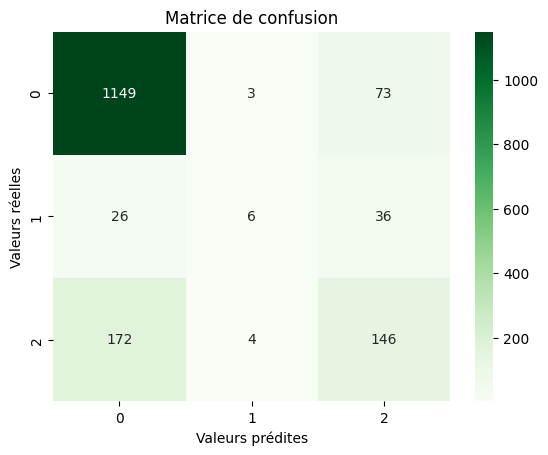

In [ ]:
#Matrice de confusion
cm = confusion_matrix(y_test, y_pred_reg)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## SVM

In [ ]:
model_svm = SVC()
model_svm.fit(X_train, y_train)

SVC()

In [ ]:
y_pred_svm = model_svm.predict(X_test)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recal_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_score_svm = f1_score(y_test, y_pred_svm, average='weighted')

In [ ]:
print("Accuracy :", accuracy_svm)
print("Précision :", precision_svm)
print("Recall :", recal_svm)
print("F1 Score :", f1_score_svm)

Accuracy : 0.8241486068111455
Précision : 0.8180341927600967
Recall : 0.8241486068111455
F1 Score : 0.797155044819701


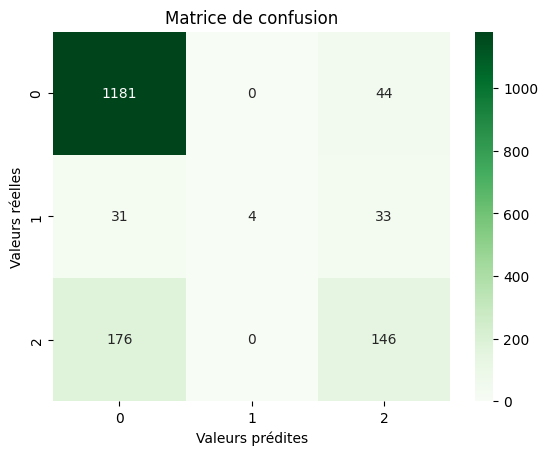

In [ ]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## RandomForest

In [ ]:
model_rand = RandomForestClassifier()
model_rand.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rand = model_rand.predict(X_test)

In [ ]:
accuracy_rand = accuracy_score(y_test, y_pred_rand)
precision_rand = precision_score(y_test, y_pred_rand, average='weighted')
recal_rand = recall_score(y_test, y_pred_rand, average='weighted')
f1_score_rand = f1_score(y_test, y_pred_rand, average='weighted')

In [ ]:
print("Accuracy :", accuracy_rand)
print("Précision :", precision_rand)
print("Recall :", recal_rand)
print("F1-score :", f1_score_rand)


Accuracy : 0.9226006191950464
Précision : 0.9207376915443118
Recall : 0.9226006191950464
F1-score : 0.9186129548420777


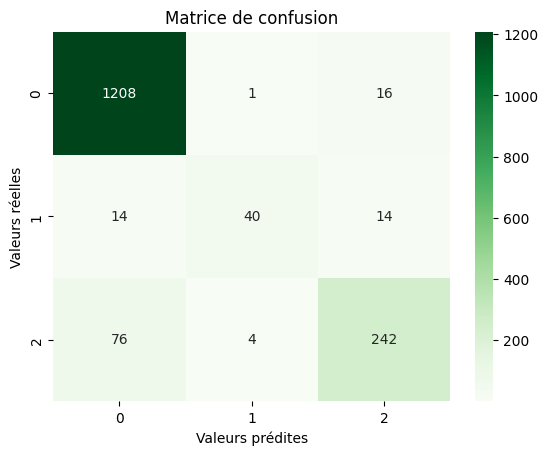

In [ ]:
cm = confusion_matrix(y_test, y_pred_rand)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de confusion")
plt.xlabel("Valeurs prédites")
plt.ylabel("Valeurs réelles")
plt.show()

## Comparaison

In [ ]:
results = [
    {"Model Sc1": "Logistic Regression", "Accuracy": accuracy_reg, "Precision": precision_reg, "Recall": recal_reg, "F1 Score": f1_score_reg},
    {"Model Sc1": "SVM", "Accuracy": accuracy_svm, "Precision": precision_svm, "Recall": recal_svm, "F1 Score": f1_score_svm},
    {"Model Sc1": "Random Forest", "Accuracy": accuracy_rand, "Precision": precision_rand, "Recall": recal_rand, "F1 Score": f1_score_reg}
]

In [ ]:
tab_comp = pd.DataFrame(results)

In [ ]:
tab_comp

,Model Sc1,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.805573,0.780606,0.805573,0.784846
1,SVM,0.824149,0.818034,0.824149,0.797155
2,Random Forest,0.922601,0.920738,0.922601,0.784846
